<a href="https://colab.research.google.com/github/Jarvis-BITS/midodrine-mimic-iv/blob/main/notebook/01_cohort_data_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [1]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.3)
import sys
import warnings
warnings.filterwarnings('ignore')

Authenticate with GCP account having MIMIC-IV dataset

In [2]:
from google.colab import auth

auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
%load_ext google.colab.data_table

In [4]:
%load_ext google.cloud.bigquery

In [5]:
project_id = "mit-midodrine" #@param {type:"string"} #Enter your project ID from GCP bigquey here
bqclient = bigquery.Client(project=project_id)

# BigQuery data extraction of patient details in ICU (1st day)

In [6]:
population_string = """
WITH patient_details AS (
  SELECT
  ie.subject_id, ie.hadm_id, ie.stay_id
  , pat.gender, ie.ethnicity, adm.language
  , ie.admittime, ie.dischtime
  , DATETIME_DIFF(ie.admittime, DATETIME(pat.anchor_year, 1, 1, 0, 0, 0), YEAR) + pat.anchor_age AS age
  , adm.deathtime
  , ie.hospital_expire_flag

-- icu level factors
  , ie.icu_intime, ie.icu_outtime
  , ie.first_icu_stay
  , ie.los_icu, ie.los_hospital
  FROM `physionet-data.mimic_derived.icustay_detail` ie
  INNER JOIN `physionet-data.mimic_core.admissions` adm
  ON ie.hadm_id = adm.hadm_id
  INNER JOIN `physionet-data.mimic_core.patients` pat
  ON ie.subject_id = pat.subject_id

-- midodrine cohort
  )
  , midodrine AS (
    SELECT hadm_id, pharmacy_id
    , starttime AS drug_starttime
    , stoptime AS drug_stoptime
    FROM `physionet-data.mimic_hosp.prescriptions`
    WHERE lower(drug) LIKE '%midodrine%'
  )
  , midodrine_exclude AS (
    SELECT stay_id,
    CASE WHEN LOGICAL_AND(drug_starttime < DATE_TRUNC(intime - interval '1' day, DAY) OR drug_starttime > outtime) THEN 1 
    ELSE 0 END AS midodrine_exclude
    FROM `physionet-data.mimic_icu.icustays` 
    LEFT JOIN midodrine USING (hadm_id)
    GROUP BY stay_id
  )
  , midodrine_include AS (
    SELECT stay_id,
    CASE WHEN LOGICAL_AND(drug_starttime is NULL)
    OR LOGICAL_OR(drug_starttime BETWEEN DATE_TRUNC(intime - interval '1' day, DAY) AND outtime) THEN 1
    ELSE 0 END AS midodrine_include
    FROM `physionet-data.mimic_icu.icustays`  
    LEFT JOIN midodrine USING (hadm_id)
    GROUP BY stay_id
  )
  , midodrine_first AS (
  SELECT stay_id, min(drug_starttime) AS drug_starttime, max(drug_stoptime) AS drug_stoptime
  FROM `physionet-data.mimic_icu.icustays` LEFT JOIN midodrine mi USING (hadm_id)
  WHERE drug_starttime BETWEEN DATE_TRUNC(intime - interval '1' day, DAY) AND outtime
  GROUP BY stay_id
  )
 , midodrine_dose AS (
  SELECT ic.stay_id, AVG(per.doses_per_24_hrs) as avg_doses_per_24_hrs
  FROM `physionet-data.mimic_hosp.prescriptions` per
  INNER JOIN `physionet-data.mimic_icu.icustays`ic
  ON per.hadm_id = ic.hadm_id
  GROUP BY ic.stay_id 
  )

 , sepsis3 AS (
   SELECT stay_id, sepsis3
   FROM `physionet-data.mimic_derived.sepsis3`
 )

  , adm_weekday AS (
    SELECT stay_id,
      EXTRACT(DAYOFWEEK FROM intime) AS adm_weekday
    FROM `physionet-data.mimic_icu.icustays`
  )

  , population AS (
    SELECT *  
    FROM (SELECT DISTINCT stay_id, first_careunit, FROM `physionet-data.mimic_icu.icustays`) a
    LEFT JOIN patient_details USING (stay_id)
    LEFT JOIN midodrine_first USING (stay_id)
    LEFT JOIN midodrine_exclude USING (stay_id)
    LEFT JOIN midodrine_include USING (stay_id)
    LEFT JOIN midodrine_dose USING (stay_id)
    LEFT JOIN sepsis3 USING (stay_id)
    LEFT JOIN adm_weekday USING (stay_id)
    )
    SELECT * FROM population
"""

In [7]:
vasopressor_id = """
SELECT DISTINCT stay_id FROM  `physionet-data.mimic_derived.epinephrine`
UNION DISTINCT
SELECT DISTINCT stay_id FROM  `physionet-data.mimic_derived.dobutamine`
UNION DISTINCT
SELECT DISTINCT stay_id FROM  `physionet-data.mimic_derived.dopamine`
UNION DISTINCT
SELECT DISTINCT stay_id FROM  `physionet-data.mimic_derived.norepinephrine`
UNION DISTINCT
SELECT DISTINCT stay_id FROM `physionet-data.mimic_derived.phenylephrine`
UNION DISTINCT
SELECT DISTINCT stay_id FROM  `physionet-data.mimic_derived.vasopressin`
"""

In [8]:
basic_string = """
WITH sapsii AS (
  SELECT stay_id, sapsii
  FROM `physionet-data.mimic_derived.sapsii`
  )
  
  , sirs AS(
  SELECT stay_id, sirs
  FROM `physionet-data.mimic_derived.sirs`
  )

  , basic AS (
  SELECT *
  FROM (SELECT DISTINCT stay_id FROM `physionet-data.mimic_icu.icustays`)
  LEFT JOIN sapsii USING (stay_id)
  LEFT JOIN sirs USING (stay_id)
  )
SELECT * FROM basic
"""

In [9]:
comorbidities_string = """
WITH charlson AS(
  SELECT ic.stay_id
  , char.charlson_comorbidity_index
  , char.renal_diseASe AS Renal
  , char.severe_liver_disease AS severe_liver
  , char.mild_liver_disease AS mild_liver
  , char.chronic_pulmonary_disease AS CPD_or_COPD
  , char.malignant_cancer AS Maligancy
  , char.aids AS aids
  FROM `physionet-data.mimic_derived.charlson` char
  INNER JOIN `physionet-data.mimic_icu.icustays` ic
  USING(hadm_id)
)
, diag AS
(
  SELECT 
      hadm_id
      , CASE WHEN icd_version = 9 THEN icd_code ELSE NULL END AS icd9_code
      , CASE WHEN icd_version = 10 THEN icd_code ELSE NULL END AS icd10_code
  FROM `physionet-data.mimic_hosp.diagnoses_icd` diag
)
, addition AS(
  SELECT ic.stay_id
  -- CAD
  , MAX(CASE WHEN
      icd9_code LIKE '414%'
      OR
      SUBSTR(icd10_code, 1, 4) = 'I251'
      THEN 1 
      ELSE 0 END) AS CAD
  -- AFIB
  , MAX(CASE WHEN
      icd9_code LIKE '4273%'
      OR
      SUBSTR(icd10_code, 1, 3) = 'I48'
      THEN 1 
      ELSE 0 END) AS AFIB
  FROM `physionet-data.mimic_icu.icustays` ic
  INNER JOIN diag
  USING(hadm_id)
  GROUP BY ic.stay_id
)
, comorbidities AS(
  SELECT ic.stay_id
    , charlson.charlson_comorbidity_index AS charlson_index
    , charlson.CPD_or_COPD AS CPD_or_COPD
    , charlson.Maligancy AS Maligancy
    , charlson.mild_liver AS Mild_Liver
    , charlson.severe_liver AS Severe_Liver
    , charlson.Renal AS Renal
    , charlson.aids AS AIDS
    , addition.CAD AS CAD_rate
    , addition.AFIB AS AFIB_rate
  FROM `physionet-data.mimic_icu.icustays` ic
  LEFT JOIN charlson USING (stay_id)
  LEFT JOIN addition USING (stay_id)
)
SELECT * FROM comorbidities
"""

In [10]:
interventions_string = """
-- sedative extract
WITH sedative AS (
    SELECT ic.stay_id
      , MAX(CASE WHEN ip.itemid in (221668,221744,225972,225942,222168) THEN 1 ELSE 0 END) AS sedative_use
    FROM `physionet-data.mimic_icu.icustays` ic
    INNER JOIN `physionet-data.mimic_icu.inputevents` ip USING (stay_id)
    WHERE ip.starttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
    GROUP BY ic.stay_id
)

-- vasopressor
, vasopressin AS (
    SELECT ic.stay_id
      , MAX(CASE WHEN ic.stay_id in (SELECT stay_id FROM `physionet-data.mimic_derived.vasopressin`) THEN 1 ELSE 0 END) AS vasopressin_use
      , MIN(starttime) AS pressin_starttime
      , MAX(endtime) AS pressin_endtime
      , AVG(vaso_rate) AS pressin_rate
    FROM `physionet-data.mimic_derived.vasopressin` iv
    INNER JOIN `physionet-data.mimic_icu.icustays` ic USING (stay_id)
    WHERE iv.starttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
    GROUP BY ic.stay_id
)
, dobutamine AS (
    SELECT ic.stay_id
      , MAX(CASE WHEN ic.stay_id in (SELECT stay_id FROM `physionet-data.mimic_derived.dobutamine`) THEN 1 ELSE 0 END) AS dobutamine_use
      , MIN(starttime) AS dobut_starttime
      , MAX(endtime) AS dobut_endtime
      , AVG(vaso_rate) AS dobut_rate
    FROM `physionet-data.mimic_derived.dobutamine` idb
    INNER JOIN `physionet-data.mimic_icu.icustays` ic USING (stay_id)
    WHERE idb.starttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
    GROUP BY ic.stay_id
)
, dopamine AS (
    SELECT ic.stay_id
      , MAX(CASE WHEN ic.stay_id in (SELECT stay_id FROM `physionet-data.mimic_derived.dopamine`) THEN 1 ELSE 0 END) AS dopamine_use
      , MIN(starttime) AS dopa_starttime
      , MAX(endtime) AS dopa_endtime
      , AVG(vaso_rate) AS dopa_rate
    FROM `physionet-data.mimic_derived.dopamine` idp
    INNER JOIN `physionet-data.mimic_icu.icustays` ic USING (stay_id)
    WHERE idp.starttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
    GROUP BY ic.stay_id
)
, epinephrine AS (
    SELECT ic.stay_id
      , MAX(CASE WHEN ic.stay_id in (SELECT stay_id FROM `physionet-data.mimic_derived.epinephrine`) THEN 1 ELSE 0 END) AS epinephrine_use
      , MIN(starttime) AS epi_starttime
      , MAX(endtime) AS epi_endtime
      , AVG(vaso_rate) AS epi_rate
    FROM `physionet-data.mimic_derived.epinephrine` iep
    INNER JOIN `physionet-data.mimic_icu.icustays` ic USING (stay_id)
    WHERE iep.starttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
    GROUP BY ic.stay_id
)
, milrinone AS (
    SELECT ic.stay_id
      , MAX(CASE WHEN ic.stay_id in (SELECT stay_id FROM `physionet-data.mimic_derived.milrinone`) THEN 1 ELSE 0 END) AS milrinone_use
    FROM `physionet-data.mimic_derived.milrinone` iml
    INNER JOIN `physionet-data.mimic_icu.icustays` ic USING (stay_id)
    WHERE iml.starttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
    GROUP BY ic.stay_id
)
, norepinephrine AS (
    SELECT ic.stay_id
      , MAX(CASE WHEN ic.stay_id in (SELECT stay_id FROM `physionet-data.mimic_derived.norepinephrine`) THEN 1 ELSE 0 END) AS norepinephrine_use
      , MIN(starttime) AS norepi_starttime
      , MAX(endtime) AS norepi_endtime
      , AVG(vaso_rate) AS norepi_rate
    FROM `physionet-data.mimic_derived.norepinephrine` inrp
    INNER JOIN `physionet-data.mimic_icu.icustays` ic USING (stay_id)
    WHERE inrp.starttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
    GROUP BY ic.stay_id
)
, phenylephrine AS (
    SELECT ic.stay_id
      , MAX(CASE WHEN ic.stay_id in (SELECT stay_id FROM `physionet-data.mimic_derived.phenylephrine`) THEN 1 ELSE 0 END) AS phenylephrine_use
      , MIN(starttime) AS phenyl_starttime
      , MAX(endtime) AS phenyl_endtime
      , AVG(vaso_rate) AS phenyl_rate
    FROM `physionet-data.mimic_derived.phenylephrine` iphe
    INNER JOIN `physionet-data.mimic_icu.icustays` ic USING (stay_id)
    WHERE iphe.starttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
    GROUP BY ic.stay_id
)

-- ventilation
, ventilation AS (
  SELECT ic.stay_id
    , MAX(CASE WHEN ic.stay_id in (SELECT stay_id FROM `physionet-data.mimic_derived.ventilation`) THEN 1 ELSE 0 END) AS ventilation_use
    FROM `physionet-data.mimic_icu.icustays` ic
    INNER JOIN `physionet-data.mimic_derived.ventilation` ivn USING (stay_id)
    WHERE ivn.starttime BETWEEN DATE_TRUNC(ic.intime-interval'1'day, DAY) AND ic.outtime
    GROUP BY ic.stay_id
)

, interventions as (
    SELECT *
    FROM (SELECT DISTINCT stay_id FROM `physionet-data.mimic_icu.icustays`) a
    LEFT JOIN sedative USING (stay_id)
    LEFT JOIN ventilation USING (stay_id)
    LEFT JOIN vasopressin USING (stay_id)
    LEFT JOIN dobutamine USING (stay_id)
    LEFT JOIN dopamine USING (stay_id)
    LEFT JOIN epinephrine USING (stay_id)
    LEFT JOIN norepinephrine USING (stay_id)
    LEFT JOIN phenylephrine USING (stay_id)
    LEFT JOIN milrinone USING (stay_id)
)

SELECT * FROM interventions;
"""

In [11]:
weight_string = """
SELECT  ie.stay_id
, AVG(CASE WHEN weight_type = 'admit' THEN ce.weight ELSE NULL END) AS weight
FROM `physionet-data.mimic_icu.icustays` ie
  -- admission weight
LEFT JOIN `physionet-data.mimic_derived.weight_durations` ce
    ON ie.stay_id = ce.stay_id
    -- we filter to weights documented during or before the 1st day
    AND ce.starttime <= DATETIME_ADD(ie.intime, INTERVAL '1' DAY)
GROUP BY ie.subject_id, ie.stay_id
"""

In [12]:
mortality_string = """
SELECT ic.stay_id,
MAX(CASE WHEN pa.dod <= DATETIME_ADD(ic.intime , INTERVAL '28' DAY) AND pa.dod >= ic.intime THEN 1 ELSE 0 END) AS mort_28_day
FROM `physionet-data.mimic_icu.icustays` ic
LEFT JOIN `physionet-data.mimic_core.patients` pa
ON ic.subject_id = pa.subject_id
GROUP BY ic.stay_id
"""

## Queries to be filtered on drug time

In [13]:
sofa_score_string = """
SELECT stay_id, starttime, endtime, sofa_24hours
FROM `physionet-data.mimic_derived.sofa`
"""

In [14]:
vitals_string = """
SELECT stay_id, charttime
, heart_rate
, sbp
, dbp  
, mbp  
, resp_rate 
, temperature 
, spo2
, glucose
FROM `physionet-data.mimic_derived.vitalsign` 
"""

In [15]:
blood_count_string = """
SELECT hadm_id, charttime
, hemoglobin, hematocrit, platelet, wbc
FROM `physionet-data.mimic_derived.complete_blood_count`
WHERE hadm_id IS NOT NULL
"""

In [16]:
chemistry_string = """
SELECT hadm_id, charttime
, sodium, potassium, bicarbonate, chloride, bun, creatinine
FROM `physionet-data.mimic_derived.chemistry`
WHERE hadm_id IS NOT NULL
"""

In [17]:
bg_string = """
SELECT hadm_id, charttime
, lactate, ph, po2, pco2
FROM `physionet-data.mimic_derived.bg`
WHERE hadm_id IS NOT NULL
"""

In [18]:
cardiac_marker_string = """
SELECT hadm_id, charttime
, CASE WHEN ntprobnp is not null THEN 1 ELSE 0 END AS bnp
, CASE WHEN troponin_t is not null THEN 1 ELSE 0 END AS troponin
, CASE WHEN ck_mb is not null THEN 1 ELSE 0 END AS creatinine_kinase
FROM `physionet-data.mimic_derived.cardiac_marker`
WHERE hadm_id IS NOT NULL
"""

# Building cohort table

## Extract population info

In [19]:
population_data = (
    bqclient.query(population_string)
    .result()
    .to_dataframe()
)

In [20]:
population_data

,stay_id,first_careunit,subject_id,hadm_id,gender,ethnicity,language,admittime,dischtime,age,...,first_icu_stay,los_icu,los_hospital,drug_starttime,drug_stoptime,midodrine_exclude,midodrine_include,avg_doses_per_24_hrs,sepsis3,adm_weekday
0,34547665,Neuro Stepdown,12776735,20817525,M,OTHER,ENGLISH,2200-07-11 22:46:00,2200-07-19 12:00:00,80,...,True,1.67,8,NaT,NaT,0,1,2.120000,True,7
1,39289362,Neuro Stepdown,16256226,20013290,F,OTHER,ENGLISH,2150-12-20 03:00:00,2150-12-21 14:50:00,49,...,True,0.92,1,NaT,NaT,0,1,1.428571,None,1
2,32563675,Neuro Stepdown,12974563,29618057,F,WHITE,ENGLISH,2138-11-13 01:07:00,2138-11-15 15:53:00,72,...,True,1.71,2,NaT,NaT,0,1,1.434783,None,5
3,34947848,Neuro Stepdown,14609218,20606189,F,WHITE,ENGLISH,2174-06-28 20:40:00,2174-07-05 16:45:00,69,...,True,6.83,7,NaT,NaT,0,1,1.428571,None,3
4,37445058,Neuro Stepdown,12687112,26132667,M,BLACK/AFRICAN AMERICAN,ENGLISH,2162-05-31 15:36:00,2162-06-04 10:16:00,63,...,True,3.67,4,NaT,NaT,0,1,1.666667,None,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76535,39980385,Medical/Surgical Intensive Care Unit (MICU/SICU),11392990,21253505,M,WHITE,ENGLISH,2158-08-10 04:50:00,2158-08-13 17:45:00,73,...,True,1.63,3,NaT,NaT,0,1,1.592593,True,5
76536,39985296,Medical/Surgical Intensive Care Unit (MICU/SICU),19632565,29295929,F,WHITE,ENGLISH,2179-04-26 14:22:00,2179-05-02 16:00:00,59,...,True,6.25,6,NaT,NaT,0,1,1.666667,None,2
76537,39987031,Medical/Surgical Intensive Care Unit (MICU/SICU),12762280,23194856,F,WHITE,ENGLISH,2177-12-07 21:34:00,2177-12-16 17:43:00,82,...,True,2.04,9,NaT,NaT,0,1,2.035714,None,7
76538,39989040,Medical/Surgical Intensive Care Unit (MICU/SICU),18311244,22780979,M,WHITE,ENGLISH,2187-04-04 23:57:00,2187-04-08 15:45:00,58,...,True,0.54,4,NaT,NaT,0,1,1.727273,True,5


In [21]:
population_data.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76540 entries, 0 to 76539
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   stay_id               76540 non-null  int64         
 1   first_careunit        76540 non-null  object        
 2   subject_id            76540 non-null  int64         
 3   hadm_id               76540 non-null  int64         
 4   gender                76540 non-null  object        
 5   ethnicity             76540 non-null  object        
 6   language              76540 non-null  object        
 7   admittime             76540 non-null  datetime64[ns]
 8   dischtime             76540 non-null  datetime64[ns]
 9   age                   76540 non-null  int64         
 10  deathtime             8813 non-null   datetime64[ns]
 11  hospital_expire_flag  76540 non-null  int64         
 12  icu_intime            76540 non-null  datetime64[ns]
 13  icu_outtime     

## Building the cohort table (consisting of only ICU patients)
1. Include adults (>= 18 years' old)
2. Include the first ICU admission of each patient
3. Exclude those who discharged or expired before 24 hours in ICU
4. Include patients whose ICU care is 'MICU' or 'SICU'
5. Include patients who have sepsis
6. Include patients who recived atleast one treartment of vasopressors
7. Exclude those who accepted midodrine more than one day before icu care or after icu care (have been done before)

Note: midodrine_include is just opposite of midodrine_exclude so use either of the two for this

Filtering on age

In [22]:
cohort_1 = population_data.loc[population_data['age'] >= 18]
cohort_1.shape

(76540, 24)

Filtering on first ICU admission

In [23]:
cohort_2 = cohort_1.loc[cohort_1['first_icu_stay']  == True]
cohort_2.shape

(69211, 24)

Filtering out if death/discharge before 24hrs of intime

In [24]:
# 24 hrs = 86400s ;(24x60x60)
cohort_3 = cohort_2.loc[((cohort_2['deathtime'] - cohort_2['icu_intime']).dt.total_seconds() > 86400) | (cohort_2['deathtime'].isnull())] # Passed away after 24hrs or alive
cohort_3 = cohort_3.loc[((cohort_3['icu_outtime'] - cohort_3['icu_intime']).dt.total_seconds() > 86400)] # Discharged in 24hrs 
cohort_3 = cohort_3.loc[((cohort_3['dischtime'] - cohort_3['icu_intime']).dt.total_seconds() > 86400)] # Discharged in 24hrs 
cohort_3.shape

(54187, 24)

 Filtering in only MICU & SICU first care units

In [25]:
cohort_4 = cohort_3.loc[cohort_3['first_careunit'].str.contains("micu|sicu", case=False)]
cohort_4.shape

(36115, 24)

Filtering on sepsis 

In [26]:
cohort_5 = cohort_4.loc[cohort_4['sepsis3']  == True]
cohort_5.shape

(19915, 24)

Filtering on vasopressor treatments

In [27]:
vaso_id = (
    bqclient.query(vasopressor_id)
    .result()
    .to_dataframe()   
)

In [28]:
vaso_id

,stay_id
0,31326208
1,34349568
2,30682880
3,39679232
4,33257984
...,...
24337,34452478
24338,36711167
24339,37764095
24340,31965951


In [29]:
cohort_6 = pd.merge(cohort_5, vaso_id, on='stay_id', how='inner')
cohort_6.shape

(8834, 24)

Filtering on midodrine ***perscribed*** for first time

In [30]:
cohort_table = cohort_6.loc[cohort_6['midodrine_include'] == 1]
cohort_table.shape

(8674, 24)

## Extract the weight

In [27]:
weight_data = (
    bqclient.query(weight_string)
    .result()
    .to_dataframe()
)

In [28]:
weight_data

,stay_id,weight
0,39289362,54.0
1,32563675,90.7
2,34947848,53.9
3,37445058,119.1
4,30056748,44.0
...,...,...
76535,38721510,79.0
76536,30062692,79.0
76537,31908710,79.0
76538,32159208,79.0


## Extract the basic score (sirs, sapsii)

In [107]:
basic_data = (
    bqclient.query(basic_string)
    .result()
    .to_dataframe()
)

In [108]:
basic_data.describe()

,stay_id,sapsii,sirs
count,7.654000e+04,76540.000000,76540.000000
mean,3.499480e+07,34.803906,2.485367
std,2.888755e+06,13.911267,0.964767
min,3.000015e+07,0.000000,0.000000
25%,3.249232e+07,25.000000,2.000000
50%,3.499660e+07,33.000000,3.000000
75%,3.749222e+07,42.000000,3.000000
max,3.999981e+07,114.000000,4.000000


## Extract the mortality

In [31]:
mortality_data = (
    bqclient.query(mortality_string)
    .result()
    .to_dataframe()
)

In [32]:
mortality_data

,stay_id,mort_28_day
0,34547665,0
1,39289362,0
2,32563675,0
3,34947848,0
4,37445058,0
...,...,...
76535,39867006,1
76536,39876847,1
76537,39977793,1
76538,39985296,1


## Extract the Comorbidities

In [33]:
comorbidities_data = (
    bqclient.query(comorbidities_string)
    .result()
    .to_dataframe()
)

In [34]:
comorbidities_data.describe()

,stay_id,charlson_index,CPD_or_COPD,Maligancy,Mild_Liver,Severe_Liver,Renal,AIDS,CAD_rate,AFIB_rate
count,7.654000e+04,76540.000000,76540.000000,76540.000000,76540.000000,76540.000000,76540.000000,76540.000000,76504.000000,76504.000000
mean,3.499480e+07,5.621936,0.259211,0.131761,0.119036,0.055344,0.218853,0.007290,0.294115,0.294756
std,2.888755e+06,3.027045,0.438204,0.338233,0.323833,0.228651,0.413471,0.085072,0.455647,0.455936
min,3.000015e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.249232e+07,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.499660e+07,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.749222e+07,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,3.999981e+07,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Extract interventions

In [32]:
interventions_data = (
    bqclient.query(interventions_string)
    .result()
    .to_dataframe()
)

In [33]:
interventions_data = pd.merge(interventions_data, vaso_id, on='stay_id', how='inner')

In [34]:
vaso_st_time = interventions_data.loc[:,['pressin_starttime', 'dobut_starttime', 'dopa_starttime', 'epi_starttime', 'norepi_starttime', 'phenyl_starttime']]
vaso_end_time = interventions_data.loc[:,['pressin_endtime', 'dobut_endtime', 'dopa_endtime', 'epi_endtime', 'norepi_endtime', 'phenyl_endtime']]

In [35]:
interventions_data['vaso_starttime'] = vaso_st_time.min(axis = 1, skipna = True)
interventions_data['vaso_endtime'] = vaso_end_time.max(axis = 1, skipna = True)

In [36]:
interventions_data

,stay_id,sedative_use,ventilation_use,vasopressin_use,pressin_starttime,pressin_endtime,pressin_rate,dobutamine_use,dobut_starttime,dobut_endtime,...,norepi_starttime,norepi_endtime,norepi_rate,phenylephrine_use,phenyl_starttime,phenyl_endtime,phenyl_rate,milrinone_use,vaso_starttime,vaso_endtime
0,31288968,1.0,1.0,NaN,NaT,NaT,NaN,NaN,NaT,NaT,...,NaT,NaT,NaN,1.0,2168-04-24 08:00:00,2168-04-25 04:58:00,0.233352,NaN,2168-04-24 08:00:00,2168-04-25 04:58:00
1,36009221,0.0,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaT,...,2154-11-04 12:00:00,2154-11-04 12:30:00,0.020002,1.0,2154-11-04 11:55:00,2154-11-04 16:05:00,0.030000,NaN,2154-11-04 11:55:00,2154-11-04 16:05:00
2,37456416,1.0,1.0,NaN,NaT,NaT,NaN,NaN,NaT,NaT,...,NaT,NaT,NaN,1.0,2121-06-18 23:30:00,2121-06-19 07:19:00,0.625337,NaN,2121-06-18 23:30:00,2121-06-19 07:19:00
3,37630189,1.0,1.0,NaN,NaT,NaT,NaN,NaN,NaT,NaT,...,2145-08-06 00:12:00,2145-08-07 10:13:00,0.115534,1.0,2145-08-05 10:52:00,2145-08-06 00:31:00,0.912337,NaN,2145-08-05 10:52:00,2145-08-07 10:13:00
4,32715685,1.0,1.0,NaN,NaT,NaT,NaN,NaN,NaT,NaT,...,2123-05-27 15:54:00,2123-05-27 17:21:00,0.045018,1.0,2123-05-27 00:33:00,2123-05-27 18:08:00,0.375169,NaN,2123-05-27 00:33:00,2123-05-27 18:08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24337,39851163,1.0,1.0,NaN,NaT,NaT,NaN,NaN,NaT,NaT,...,2163-10-14 03:15:00,2163-10-14 11:32:00,0.061460,NaN,NaT,NaT,NaN,NaN,2163-10-14 03:15:00,2163-10-14 11:32:00
24338,39867006,1.0,1.0,NaN,NaT,NaT,NaN,NaN,NaT,NaT,...,2140-10-09 07:00:00,2140-10-11 11:56:00,0.090591,NaN,NaT,NaT,NaN,NaN,2140-10-09 07:00:00,2140-10-11 11:56:00
24339,39906695,0.0,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaT,...,2111-09-13 06:46:00,2111-09-13 07:15:00,0.065024,NaN,NaT,NaT,NaN,NaN,2111-09-13 06:46:00,2111-09-13 07:15:00
24340,39918058,1.0,1.0,1.0,2159-06-28 18:13:00,2159-07-02 03:59:00,2.206047,NaN,NaT,NaT,...,2159-06-25 20:05:00,2159-07-21 15:53:00,0.083372,NaN,NaT,NaT,NaN,NaN,2159-06-25 20:05:00,2159-07-21 15:53:00


## Extract Vital Signs

In [197]:
vitals = (
    bqclient.query(vitals_string)
    .result()
    .to_dataframe()
)

In [198]:
vitals

,stay_id,charttime,heart_rate,sbp,dbp,mbp,resp_rate,temperature,spo2,glucose
0,31747890,2181-02-17 23:00:00,122.0,118.0,91.0,97.0,35.0,NaN,97.0,NaN
1,32494377,2136-03-11 20:00:00,86.0,129.0,36.0,60.0,16.5,37.50,97.0,NaN
2,39552719,2172-01-05 01:00:00,74.0,93.0,39.0,52.0,34.0,NaN,99.0,NaN
3,38097393,2176-06-24 08:00:00,85.0,77.0,37.0,53.0,33.0,36.67,97.0,NaN
4,30132321,2153-11-29 07:00:00,91.0,114.0,95.0,98.0,43.0,NaN,96.0,NaN
...,...,...,...,...,...,...,...,...,...,...
10249425,33600996,2151-10-05 02:00:00,129.0,109.0,83.0,91.0,32.0,NaN,96.0,NaN
10249426,39485582,2135-02-23 04:00:00,118.0,138.0,83.0,96.0,32.0,NaN,99.0,NaN
10249427,39221623,2118-07-15 12:00:00,128.0,130.0,83.0,99.0,32.0,35.67,98.0,NaN
10249428,38954893,2136-02-04 12:00:00,85.0,152.0,83.0,99.0,32.0,NaN,95.0,NaN


## Extract SOFA

In [199]:
sofa_score = (
    bqclient.query(sofa_score_string)
    .result()
    .to_dataframe()
)

In [200]:
sofa_score

,stay_id,starttime,endtime,sofa_24hours
0,30133203,2179-05-01 11:00:00,2179-05-01 12:00:00,15
1,30297632,2169-12-24 03:00:00,2169-12-24 04:00:00,15
2,30647926,2170-07-18 06:00:00,2170-07-18 07:00:00,18
3,30660587,2176-02-20 09:00:00,2176-02-20 10:00:00,16
4,31613027,2110-02-05 07:00:00,2110-02-05 08:00:00,16
...,...,...,...,...
6358762,38745960,2185-05-10 15:00:00,2185-05-10 16:00:00,14
6358763,39438112,2160-09-20 08:00:00,2160-09-20 09:00:00,14
6358764,39786646,2178-05-05 04:00:00,2178-05-05 05:00:00,14
6358765,39840219,2144-02-23 11:00:00,2144-02-23 12:00:00,14


## Extract Lab Tests Results

In [201]:
blood_count = (
    bqclient.query(blood_count_string)
    .result()
    .to_dataframe()
)

In [202]:
chemistry = (
    bqclient.query(chemistry_string)
    .result()
    .to_dataframe()
)

In [203]:
bg = (
    bqclient.query(bg_string)
    .result()
    .to_dataframe()
)

In [204]:
cardiac_marker = (
    bqclient.query(cardiac_marker_string)
    .result()
    .to_dataframe()
)

In [205]:
blood_count

,hadm_id,charttime,hemoglobin,hematocrit,platelet,wbc
0,25740306,2119-05-02 02:45:00,6.7,23.1,308.0,21.5
1,20446809,2139-09-26 14:28:00,7.1,25.7,57.0,4.4
2,26771503,2159-10-12 06:04:00,6.1,17.1,430.0,17.7
3,27368831,2178-05-22 01:41:00,7.0,23.3,306.0,7.9
4,28771876,2116-02-05 04:07:00,6.4,22.8,206.0,12.5
...,...,...,...,...,...,...
2068362,23217219,2178-09-20 06:15:00,14.4,40.5,161.0,10.6
2068363,20730816,2178-11-16 12:32:00,14.4,40.4,93.0,25.9
2068364,24210247,2123-07-25 07:20:00,14.4,40.4,200.0,4.0
2068365,25595692,2182-11-30 06:51:00,14.4,40.5,139.0,6.4


In [206]:
chemistry                                     

,hadm_id,charttime,sodium,potassium,bicarbonate,chloride,bun,creatinine
0,20204398,2190-03-04 18:12:00,124.0,3.1,30.0,77.0,57.0,2.9
1,24776727,2124-04-21 15:32:00,121.0,4.9,30.0,79.0,87.0,3.0
2,20259242,2161-08-17 15:05:00,156.0,3.9,23.0,122.0,71.0,2.7
3,27502621,2196-05-27 11:20:00,125.0,4.9,8.0,85.0,69.0,3.0
4,26923740,2150-06-03 03:48:00,125.0,4.1,33.0,73.0,83.0,5.3
...,...,...,...,...,...,...,...,...
2137259,24900575,2162-10-04 02:05:00,143.0,3.9,21.0,111.0,37.0,1.8
2137260,24733541,2184-02-06 18:00:00,143.0,5.4,22.0,111.0,35.0,1.8
2137261,29251085,2162-04-10 04:21:00,143.0,4.1,25.0,111.0,57.0,1.8
2137262,28479110,2182-01-11 07:40:00,143.0,3.4,21.0,111.0,17.0,1.8


In [207]:
bg

,hadm_id,charttime,lactate,ph,po2,pco2
0,24391286,2135-06-08 08:25:00,NaN,7.55,0.0,NaN
1,22192606,2184-06-20 20:02:00,NaN,NaN,0.0,NaN
2,29704715,2171-02-12 06:30:00,NaN,6.86,5.0,97.0
3,28486762,2120-04-22 14:49:00,NaN,7.16,5.0,87.0
4,22990077,2156-12-19 00:19:00,NaN,6.93,6.0,114.0
...,...,...,...,...,...,...
517072,28302991,2159-03-09 10:57:00,0.9,7.49,463.0,37.0
517073,29748841,2189-03-02 10:55:00,NaN,7.49,463.0,29.0
517074,26839898,2167-07-20 10:02:00,NaN,7.49,463.0,36.0
517075,29560405,2173-05-06 11:19:00,2.2,7.49,479.0,31.0


In [208]:
cardiac_marker

,hadm_id,charttime,bnp,troponin,creatinine_kinase
0,25982094,2159-01-11 21:59:00,1,0,0
1,21731455,2117-11-18 20:40:00,0,1,0
2,21731455,2117-11-20 13:10:00,0,1,0
3,28969811,2117-12-23 23:30:00,0,1,0
4,21731455,2117-11-21 05:51:00,0,1,0
...,...,...,...,...,...
192024,25571126,2118-05-22 15:00:00,0,0,1
192025,22578209,2131-03-16 17:44:00,0,1,1
192026,29262594,2119-11-30 06:29:00,0,1,1
192027,20847688,2160-08-19 09:52:00,0,1,1


## Divide the Midodrine Group

In [31]:
cohort_mid = cohort_table.loc[pd.notnull(cohort_table['drug_starttime'])]
cohort_mid

,stay_id,first_careunit,subject_id,hadm_id,gender,ethnicity,language,admittime,dischtime,age,...,first_icu_stay,los_icu,los_hospital,drug_starttime,drug_stoptime,midodrine_exclude,midodrine_include,avg_doses_per_24_hrs,sepsis3,adm_weekday
7,36014877,Trauma SICU (TSICU),11861017,27162817,M,WHITE,ENGLISH,2189-03-15 15:47:00,2189-05-06 17:00:00,87,...,True,46.42,52,2189-04-17 16:00:00,2189-04-25 11:00:00,0,1,1.605166,True,1
8,32272859,Trauma SICU (TSICU),11259141,25963696,F,WHITE,ENGLISH,2184-07-05 18:16:00,2184-08-08 15:59:00,60,...,True,24.00,34,2184-07-23 14:00:00,2184-08-08 20:00:00,0,1,1.594406,True,7
12,37039117,Medical Intensive Care Unit (MICU),10184327,21396430,M,WHITE,ENGLISH,2138-10-20 18:55:00,2138-11-01 03:00:00,89,...,True,11.33,12,2138-10-22 07:00:00,2138-10-28 10:00:00,0,1,1.087500,True,2
19,34023828,Neuro Surgical Intensive Care Unit (Neuro SICU),18010960,21782431,M,UNKNOWN,ENGLISH,2167-04-26 14:05:00,2167-05-18 13:40:00,59,...,True,18.96,22,2167-05-10 22:00:00,2167-05-18 17:00:00,0,1,1.719512,True,1
32,32309766,Neuro Surgical Intensive Care Unit (Neuro SICU),15703353,29272306,F,WHITE,ENGLISH,2181-05-17 22:14:00,2181-06-03 16:30:00,59,...,True,8.83,17,2181-05-22 16:00:00,2181-05-27 10:00:00,0,1,1.523810,True,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8783,37823328,Medical/Surgical Intensive Care Unit (MICU/SICU),10481056,21921090,M,UNKNOWN,ENGLISH,2122-12-19 09:16:00,2122-12-31 14:32:00,63,...,True,2.38,12,2122-12-20 23:00:00,2122-12-21 19:00:00,0,1,1.288889,True,7
8786,37888531,Medical/Surgical Intensive Care Unit (MICU/SICU),15885972,29782542,F,WHITE,ENGLISH,2172-07-30 17:16:00,2172-08-13 18:25:00,61,...,True,5.29,14,2172-08-08 14:00:00,2172-08-10 07:00:00,0,1,1.553571,True,3
8807,38743934,Medical/Surgical Intensive Care Unit (MICU/SICU),19894790,27933693,M,WHITE,ENGLISH,2140-08-25 17:58:00,2140-09-13 18:00:00,84,...,True,16.88,19,2140-09-01 14:00:00,2140-09-11 10:00:00,0,1,1.868421,True,5
8826,39446578,Medical/Surgical Intensive Care Unit (MICU/SICU),14781720,23795457,F,WHITE,ENGLISH,2189-01-07 21:03:00,2189-01-26 15:11:00,92,...,True,4.08,19,2189-01-26 14:00:00,2189-01-26 11:00:00,0,1,1.365385,True,5


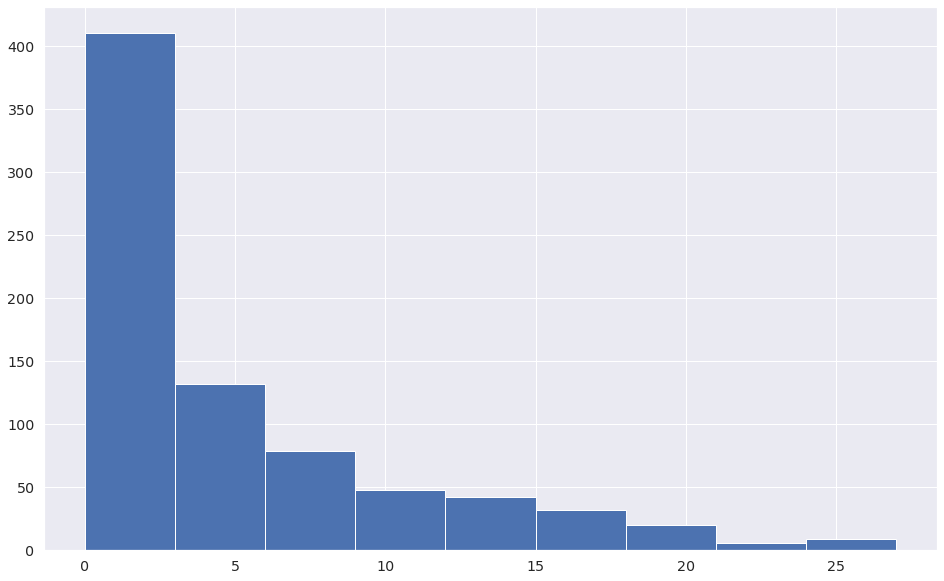

In [339]:
start_day = (cohort_mid['drug_starttime'] - cohort_mid['icu_intime']).dt.days
start_day.hist(bins = [0,3,6,9,12,15,18,21,24,27])

[]

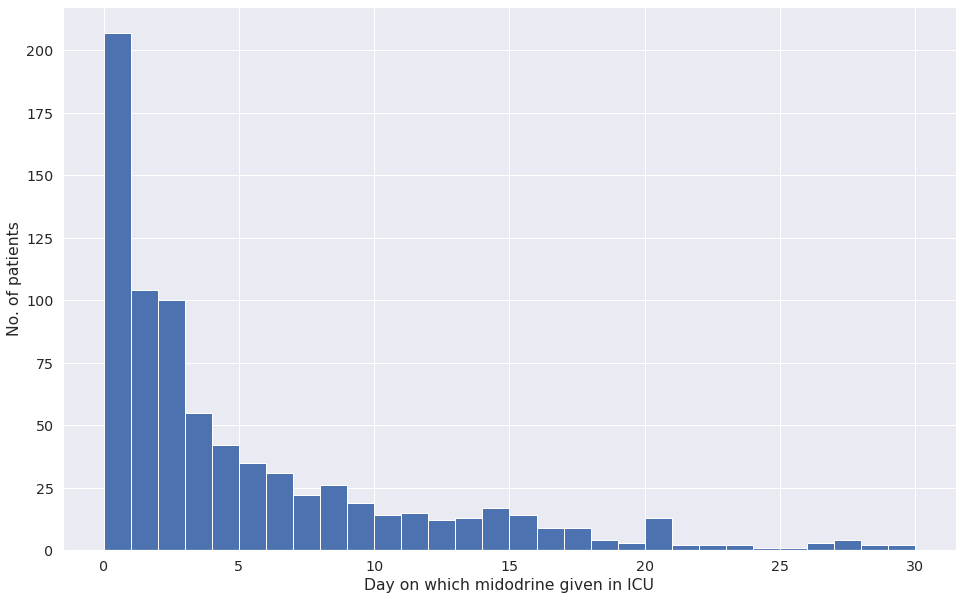

In [340]:
midodrine_day = start_day.hist(bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30])
plt.xlabel("Day on which midodrine given in ICU")
plt.ylabel("No. of patients")
plt.plot()

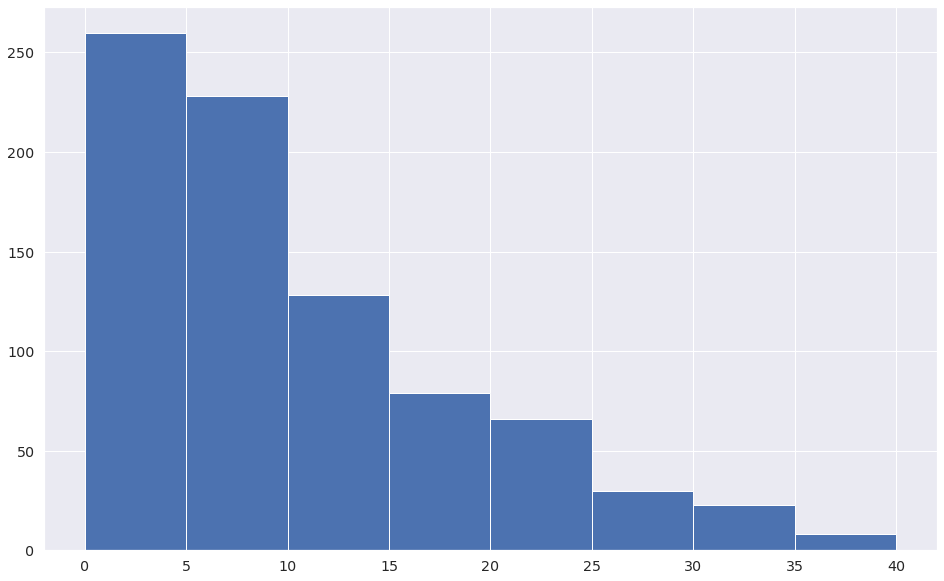

In [341]:
cohort_mid['los_icu'].hist(bins = [0,5,10,15,20,25,30,35,40])

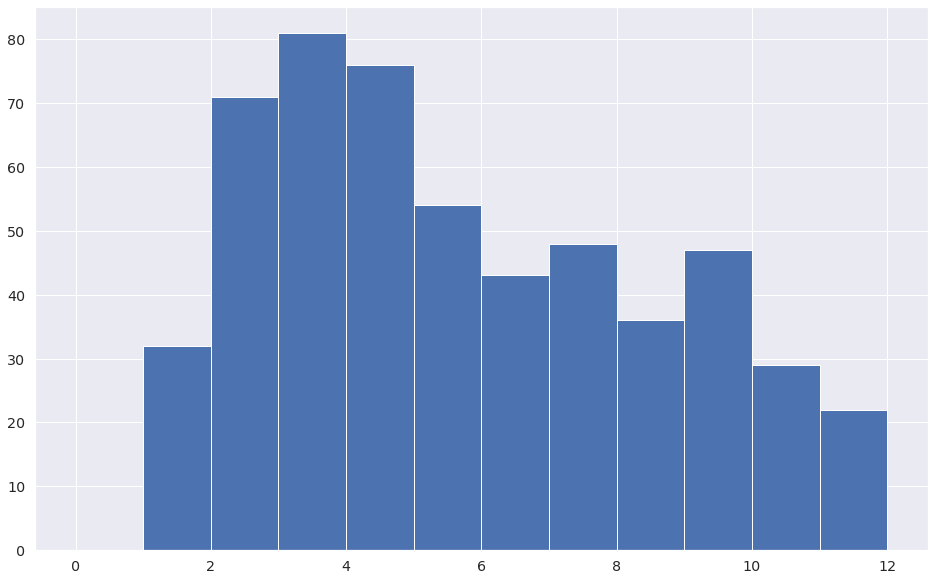

In [342]:
cohort_mid['los_icu'].hist(bins = [0,1,2,3,4,5,6,7,8,9,10,11,12])

In [343]:
mid_weights = weight_data[weight_data['stay_id'].isin(cohort_mid['stay_id'].values)]
mid_weights.describe()

,stay_id,weight
count,8.540000e+02,826.000000
mean,3.501581e+07,85.078571
std,2.870589e+06,26.483402
min,3.004562e+07,26.000000
25%,3.247602e+07,67.425000
50%,3.510308e+07,80.000000
75%,3.731437e+07,100.000000
max,3.999923e+07,230.000000


In [344]:
mid_comorbidities = comorbidities_data[comorbidities_data['stay_id'].isin(cohort_mid['stay_id'].values)]
mid_comorbidities.describe()

,stay_id,charlson_index,CPD_or_COPD,Maligancy,Mild_Liver,Severe_Liver,Renal,AIDS,CAD_rate,AFIB_rate
count,8.540000e+02,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000
mean,3.501581e+07,7.224824,0.264637,0.156909,0.428571,0.348946,0.411007,0.017564,0.240047,0.384075
std,2.870589e+06,2.859925,0.441398,0.363928,0.495162,0.476916,0.492305,0.131439,0.427362,0.486661
min,3.004562e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.247602e+07,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.510308e+07,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.731437e+07,9.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,3.999923e+07,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [345]:
mid_basic = basic_data[basic_data['stay_id'].isin(cohort_mid['stay_id'].values)]
mid_basic.describe()

,stay_id,sapsii,sirs
count,8.540000e+02,854.000000,854.000000
mean,3.501581e+07,46.139344,2.779859
std,2.870589e+06,13.811680,0.898490
min,3.004562e+07,6.000000,0.000000
25%,3.247602e+07,36.000000,2.000000
50%,3.510308e+07,45.000000,3.000000
75%,3.731437e+07,55.000000,3.000000
max,3.999923e+07,95.000000,4.000000


In [42]:
mid_interventions = interventions_data[interventions_data['stay_id'].isin(cohort_mid['stay_id'].values)]
mid_interventions.drop(['stay_id','sedative_use','ventilation_use'], axis=1).describe()

,vasopressin_use,pressin_rate,dobutamine_use,dobut_rate,dopamine_use,dopa_rate,epinephrine_use,epi_rate,norepinephrine_use,norepi_rate,phenylephrine_use,phenyl_rate,milrinone_use
count,316.0,316.000000,30.0,30.000000,57.0,57.000000,62.0,62.000000,762.0,762.000000,355.0,355.000000,11.0
mean,1.0,2.379552,1.0,4.792285,1.0,6.328834,1.0,0.159543,1.0,0.122792,1.0,1.693133,1.0
std,0.0,1.918860,0.0,3.034971,0.0,4.643349,0.0,0.314786,0.0,0.082832,0.0,2.133071,0.0
min,1.0,0.899934,1.0,1.125113,1.0,1.000055,1.0,0.010001,1.0,0.018002,1.0,0.200018,1.0
25%,1.0,1.997578,1.0,2.562907,1.0,3.389520,1.0,0.030929,1.0,0.062134,1.0,0.730055,1.0
50%,1.0,2.283786,1.0,4.077793,1.0,4.503659,1.0,0.062736,1.0,0.101502,1.0,1.183640,1.0
75%,1.0,2.401855,1.0,5.977502,1.0,7.550333,1.0,0.114022,1.0,0.158244,1.0,2.128391,1.0
max,1.0,33.250000,1.0,12.710297,1.0,23.429809,1.0,2.059225,1.0,0.599777,1.0,35.142064,1.0


In [347]:
mid_mortality = mortality_data[mortality_data['stay_id'].isin(cohort_mid['stay_id'].values)]
mid_mortality.describe()

,stay_id,mort_28_day
count,8.540000e+02,854.000000
mean,3.501581e+07,0.322014
std,2.870589e+06,0.467522
min,3.004562e+07,0.000000
25%,3.247602e+07,0.000000
50%,3.510308e+07,0.000000
75%,3.731437e+07,1.000000
max,3.999923e+07,1.000000


### Midodrine time matching

In [348]:
mid_sofa = sofa_score.merge(cohort_mid[['stay_id', 'drug_starttime', 'icu_outtime']], how='inner', on='stay_id')
mid_sofa = mid_sofa.loc[ (mid_sofa['starttime'] >= mid_sofa['drug_starttime']) & (mid_sofa['endtime'] <= mid_sofa['icu_outtime'])]
mid_sofa = mid_sofa.groupby('stay_id').mean()
mid_sofa.describe()

,sofa_24hours
count,851.000000
mean,7.268110
std,3.710100
min,0.838346
25%,4.378564
50%,6.714697
75%,9.799603
max,20.557692


In [349]:
mid_vitals = vitals.merge(cohort_mid[['stay_id', 'drug_starttime', 'icu_outtime']], how='inner', on='stay_id')
mid_vitals = mid_vitals.loc[ mid_vitals['charttime'].between(mid_vitals['drug_starttime'], mid_vitals['icu_outtime'], inclusive=True) ]
mid_vitals = mid_vitals.groupby('stay_id').mean()
mid_vitals.describe()

,heart_rate,sbp,dbp,mbp,resp_rate,temperature,spo2,glucose
count,852.000000,850.000000,850.000000,853.000000,851.000000,846.000000,852.000000,837.000000
mean,85.247768,106.409712,56.407318,70.538071,19.743573,36.793189,96.648366,311.353395
std,14.096948,12.392830,8.279103,8.127955,3.772082,0.386250,2.932583,3061.354132
min,46.536170,71.833333,36.545455,48.384615,10.250000,34.566667,43.625000,60.750000
25%,74.982908,97.921402,50.513605,65.206107,17.229021,36.599688,95.657682,111.466667
50%,84.487114,105.026978,55.808559,69.900000,19.476190,36.795938,96.976543,134.142857
75%,95.286027,113.331618,61.438414,75.392157,22.266880,36.996123,98.125650,159.525253
max,129.176136,156.913793,89.273469,106.040816,35.297030,38.235294,100.000000,62595.625000


In [350]:
mid_blood_count = blood_count.merge(cohort_mid[['hadm_id', 'drug_starttime', 'icu_outtime']], how='inner', on='hadm_id')
mid_blood_count = mid_blood_count.loc[ mid_blood_count['charttime'].between(mid_blood_count['drug_starttime'], mid_blood_count['icu_outtime'], inclusive=True) ]
mid_blood_count = mid_blood_count.groupby('hadm_id').mean()
mid_blood_count = mid_blood_count.merge(cohort_mid[['stay_id','hadm_id']], how='inner', on='hadm_id')
mid_blood_count.drop("hadm_id", axis = 1, inplace=True)
mid_blood_count.describe()

,hemoglobin,hematocrit,platelet,wbc,stay_id
count,820.000000,821.000000,820.000000,820.000000,8.210000e+02
mean,8.717618,27.222412,171.233984,12.083386,3.502281e+07
std,1.243978,3.897726,126.770188,6.427375,2.870342e+06
min,6.333333,19.366667,14.000000,0.760000,3.004562e+07
25%,7.785714,24.521053,70.986842,7.712500,3.249059e+07
50%,8.478889,26.513333,140.250000,10.691667,3.511070e+07
75%,9.350000,29.050000,231.687500,14.805556,3.731790e+07
max,15.850000,46.685714,928.714286,64.600000,3.999923e+07


In [351]:
mid_chemistry = chemistry.merge(cohort_mid[['hadm_id', 'drug_starttime', 'icu_outtime']], how='inner', on='hadm_id')
mid_chemistry = mid_chemistry.loc[ mid_chemistry['charttime'].between(mid_chemistry['drug_starttime'], mid_chemistry['icu_outtime'], inclusive=True) ]
mid_chemistry = mid_chemistry.groupby('hadm_id').mean()
mid_chemistry = mid_chemistry.merge(cohort_mid[['stay_id','hadm_id']], how='inner', on='hadm_id')
mid_chemistry.drop("hadm_id", axis = 1, inplace=True)
mid_chemistry.describe()

,sodium,potassium,bicarbonate,chloride,bun,creatinine,stay_id
count,821.000000,821.000000,821.000000,821.000000,821.000000,820.000000,8.210000e+02
mean,138.698738,4.095280,23.586418,101.985622,39.264289,2.316547,3.501167e+07
std,4.962298,0.481654,4.996265,6.218023,26.985363,1.834332,2.875458e+06
min,119.500000,3.092857,8.666667,86.166667,4.500000,0.200000,3.004562e+07
25%,135.384615,3.776596,20.250000,97.333333,20.000000,0.962500,3.247116e+07
50%,138.600000,4.050000,23.500000,101.750000,32.833333,1.820931,3.510036e+07
75%,142.000000,4.352525,27.000000,106.000000,52.277778,3.179167,3.731790e+07
max,156.500000,7.020000,41.500000,124.888889,198.142857,12.375000,3.999923e+07


In [352]:
mid_bg = bg.merge(cohort_mid[['hadm_id', 'drug_starttime', 'icu_outtime']], how='inner', on='hadm_id')
mid_bg = mid_bg.loc[ mid_bg['charttime'].between(mid_bg['drug_starttime'], mid_bg['icu_outtime'], inclusive=True) ]
mid_bg = mid_bg.groupby('hadm_id').mean()
mid_bg = mid_bg.merge(cohort_mid[['stay_id','hadm_id']], how='inner', on='hadm_id')
mid_bg.drop("hadm_id", axis = 1, inplace=True)
mid_bg.describe()

,lactate,ph,po2,pco2,stay_id
count,522.000000,577.000000,577.000000,577.000000,5.770000e+02
mean,2.469582,7.371697,86.955390,42.443709,3.509826e+07
std,2.043405,0.075200,37.790099,10.144327,2.836440e+06
min,0.500000,6.990000,23.000000,19.833333,3.004562e+07
25%,1.384375,7.330882,53.600000,35.600000,3.269524e+07
50%,1.870861,7.380000,84.857143,41.000000,3.521068e+07
75%,2.800000,7.425000,111.000000,47.500000,3.732292e+07
max,17.100000,7.570000,281.000000,86.750000,3.999923e+07


In [353]:
mid_cardiac_marker = cardiac_marker.merge(cohort_mid[['hadm_id', 'drug_starttime', 'icu_outtime']], how='inner', on='hadm_id')
mid_cardiac_marker = mid_cardiac_marker.loc[ mid_cardiac_marker['charttime'].between(mid_cardiac_marker['drug_starttime'], mid_cardiac_marker['icu_outtime'], inclusive=True) ]
mid_cardiac_marker = mid_cardiac_marker.groupby('hadm_id').mean()
mid_cardiac_marker = mid_cardiac_marker.merge(cohort_mid[['stay_id','hadm_id']], how='inner', on='hadm_id')
mid_cardiac_marker.drop("hadm_id", axis = 1, inplace=True)
mid_cardiac_marker.describe()

,bnp,troponin,creatinine_kinase,stay_id
count,196.000000,196.000000,196.000000,1.960000e+02
mean,0.104130,0.808546,0.708189,3.516613e+07
std,0.286893,0.368727,0.416817,2.908532e+06
min,0.000000,0.000000,0.000000,3.005622e+07
25%,0.000000,1.000000,0.333333,3.244786e+07
50%,0.000000,1.000000,1.000000,3.548800e+07
75%,0.000000,1.000000,1.000000,3.755671e+07
max,1.000000,1.000000,1.000000,3.994397e+07


## Divide the Non-Midodrine Group

In [38]:
cohort_nomid = cohort_table.loc[pd.isnull(cohort_table['drug_starttime'])]
cohort_nomid

,stay_id,first_careunit,subject_id,hadm_id,gender,ethnicity,language,admittime,dischtime,age,...,first_icu_stay,los_icu,los_hospital,drug_starttime,drug_stoptime,midodrine_exclude,midodrine_include,avg_doses_per_24_hrs,sepsis3,adm_weekday
0,38859960,Trauma SICU (TSICU),14470386,20124738,M,WHITE,ENGLISH,2138-04-14 03:27:00,2138-05-08 15:31:00,44,...,True,21.71,24,NaT,NaT,0,1,1.965909,True,2
1,30992197,Trauma SICU (TSICU),10670236,20938672,M,WHITE,ENGLISH,2185-07-22 22:25:00,2185-08-28 16:40:00,32,...,True,18.96,37,NaT,NaT,0,1,2.272727,True,6
2,31382786,Trauma SICU (TSICU),11975614,29023602,M,ASIAN,ENGLISH,2181-06-06 17:18:00,2181-07-14 17:15:00,30,...,True,23.21,38,NaT,NaT,0,1,2.088757,True,4
3,31617347,Trauma SICU (TSICU),17873103,27750553,M,WHITE,ENGLISH,2169-06-29 04:57:00,2169-07-17 15:10:00,36,...,True,12.46,18,NaT,NaT,0,1,2.415385,True,5
4,33521917,Trauma SICU (TSICU),11312502,25289892,F,BLACK/AFRICAN AMERICAN,ENGLISH,2202-11-02 14:26:00,2202-12-03 16:55:00,62,...,True,27.08,31,NaT,NaT,0,1,1.819149,True,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8828,39690469,Medical/Surgical Intensive Care Unit (MICU/SICU),18098524,21320524,F,WHITE,ENGLISH,2120-10-30 16:54:00,2120-11-06 13:28:00,89,...,True,2.88,7,NaT,NaT,0,1,1.644444,True,4
8829,39696826,Medical/Surgical Intensive Care Unit (MICU/SICU),10070932,24727163,F,WHITE,ENGLISH,2146-05-11 18:07:00,2146-05-16 18:45:00,37,...,True,1.54,5,NaT,NaT,0,1,1.571429,True,4
8830,39801252,Medical/Surgical Intensive Care Unit (MICU/SICU),16749537,24096764,M,WHITE,ENGLISH,2127-09-09 22:13:00,2127-09-20 15:30:00,76,...,True,1.75,11,NaT,NaT,0,1,1.389831,True,4
8831,39838873,Medical/Surgical Intensive Care Unit (MICU/SICU),15554479,20342520,M,ASIAN,?,2183-03-26 07:58:00,2183-03-30 16:19:00,49,...,True,1.46,4,NaT,NaT,0,1,1.550000,True,4


In [355]:
nomid_weights = weight_data[weight_data['stay_id'].isin(cohort_nomid['stay_id'].values)]
nomid_weights.describe()

,stay_id,weight
count,7.820000e+03,7672.000000
mean,3.497358e+07,82.243365
std,2.899115e+06,26.848527
min,3.000048e+07,1.000000
25%,3.241582e+07,65.100000
50%,3.497644e+07,78.000000
75%,3.751276e+07,94.200000
max,3.999801e+07,833.000000


In [356]:
nomid_comorbidities = comorbidities_data[comorbidities_data['stay_id'].isin(cohort_nomid['stay_id'].values)]
nomid_comorbidities.describe()

,stay_id,charlson_index,CPD_or_COPD,Maligancy,Mild_Liver,Severe_Liver,Renal,AIDS,CAD_rate,AFIB_rate
count,7.820000e+03,7820.000000,7820.000000,7820.000000,7820.000000,7820.000000,7820.000000,7820.000000,7815.000000,7815.000000
mean,3.497358e+07,6.032737,0.288619,0.175448,0.169949,0.074425,0.227494,0.010870,0.212540,0.314523
std,2.899115e+06,3.031143,0.453149,0.380374,0.375612,0.262477,0.419241,0.103696,0.409131,0.464355
min,3.000048e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.241582e+07,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.497644e+07,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.751276e+07,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,3.999801e+07,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [357]:
nomid_basic = basic_data[basic_data['stay_id'].isin(cohort_nomid['stay_id'].values)]
nomid_basic.describe()

,stay_id,sapsii,sirs
count,7.820000e+03,7820.000000,7820.000000
mean,3.497358e+07,44.343734,3.013299
std,2.899115e+06,14.741209,0.844065
min,3.000048e+07,6.000000,0.000000
25%,3.241582e+07,34.000000,3.000000
50%,3.497644e+07,43.000000,3.000000
75%,3.751276e+07,53.000000,4.000000
max,3.999801e+07,114.000000,4.000000


In [358]:
nomid_mortality = mortality_data[mortality_data['stay_id'].isin(cohort_nomid['stay_id'].values)]
nomid_mortality.describe()

,stay_id,mort_28_day
count,7.820000e+03,7820.000000
mean,3.497358e+07,0.249872
std,2.899115e+06,0.432967
min,3.000048e+07,0.000000
25%,3.241582e+07,0.000000
50%,3.497644e+07,0.000000
75%,3.751276e+07,0.000000
max,3.999801e+07,1.000000


In [41]:
nomid_interventions = interventions_data[interventions_data['stay_id'].isin(cohort_nomid['stay_id'].values)]
nomid_interventions.describe()

,vasopressin_use,pressin_rate,dobutamine_use,dobut_rate,dopamine_use,dopa_rate,epinephrine_use,epi_rate,norepinephrine_use,norepi_rate,phenylephrine_use,phenyl_rate,milrinone_use
count,1833.0,1833.000000,244.0,244.000000,493.0,493.000000,403.0,403.000000,6116.0,6116.000000,3509.0,3509.000000,89.0
mean,1.0,2.290337,1.0,4.061824,1.0,7.591469,1.0,0.158327,1.0,0.133303,1.0,1.583995,1.0
std,0.0,2.121233,0.0,2.794073,0.0,4.834477,0.0,0.265175,0.0,0.170781,0.0,5.619696,0.0
min,1.0,0.040000,1.0,0.500010,1.0,0.900104,1.0,0.010001,1.0,0.010000,1.0,0.020001,1.0
25%,1.0,1.800930,1.0,2.500053,1.0,4.156943,1.0,0.042218,1.0,0.057501,1.0,0.650294,1.0
50%,1.0,2.400000,1.0,3.434232,1.0,6.506348,1.0,0.076666,1.0,0.095932,1.0,1.022559,1.0
75%,1.0,2.400961,1.0,4.999218,1.0,10.005456,1.0,0.138447,1.0,0.167457,1.0,1.941845,1.0
max,1.0,64.020477,1.0,20.060986,1.0,52.274100,1.0,2.389600,1.0,6.399658,1.0,298.685819,1.0


### No-Midodrine time matching

In [360]:
cohort_nomid_time = pd.merge(cohort_nomid[['stay_id', 'hadm_id', 'icu_outtime']], interventions_data, on='stay_id', how='inner')

In [361]:
nomid_sofa = sofa_score.merge(cohort_nomid_time[['stay_id', 'vaso_starttime', 'icu_outtime']], how='inner', on='stay_id')
nomid_sofa = nomid_sofa.loc[ (nomid_sofa['starttime'] >= nomid_sofa['vaso_starttime']) & (nomid_sofa['endtime'] <= nomid_sofa['icu_outtime'])]
nomid_sofa = nomid_sofa.groupby('stay_id').mean()
nomid_sofa.describe()

,sofa_24hours
count,7820.000000
mean,5.889145
std,3.108859
min,0.542222
25%,3.612033
50%,5.218545
75%,7.540294
max,20.447368


In [362]:
nomid_vitals = vitals.merge(cohort_nomid_time[['stay_id', 'vaso_starttime', 'icu_outtime']], how='inner', on='stay_id')
nomid_vitals = nomid_vitals.loc[nomid_vitals['charttime'].between(nomid_vitals['vaso_starttime'], nomid_vitals['icu_outtime'], inclusive=True) ]
nomid_vitals = nomid_vitals.groupby('stay_id').mean()
nomid_vitals.describe()

,heart_rate,sbp,dbp,mbp,resp_rate,temperature,spo2,glucose
count,7820.000000,7806.000000,7806.000000,7819.000000,7820.000000,7769.000000,7819.000000,7787.000000
mean,88.466698,115.321561,61.127783,76.527532,20.463762,36.968142,96.539309,194.533425
std,14.142069,14.265476,8.948467,9.358549,3.748312,0.521798,2.640591,1942.545181
min,43.250000,46.666667,22.000000,31.571429,9.000000,32.100000,44.000000,48.500000
25%,78.463580,105.540082,55.250000,70.229544,17.779457,36.690952,95.696636,114.714286
50%,87.924682,113.665061,60.652792,75.710938,20.216751,36.953889,96.921053,134.166667
75%,97.889640,123.804480,66.718766,81.988162,22.857143,37.277107,98.016778,163.875000
max,156.105263,185.160000,108.637755,128.614973,38.313725,39.672727,100.000000,111218.444444


In [363]:
nomid_blood_count = blood_count.merge(cohort_nomid_time[['hadm_id', 'vaso_starttime', 'icu_outtime']], how='inner', on='hadm_id')
nomid_blood_count = nomid_blood_count.loc[ nomid_blood_count['charttime'].between(nomid_blood_count['vaso_starttime'], nomid_blood_count['icu_outtime'], inclusive=True) ]
nomid_blood_count = nomid_blood_count.groupby('hadm_id').mean()
nomid_blood_count = nomid_blood_count.merge(cohort_nomid[['stay_id','hadm_id']], how='inner', on='hadm_id')
nomid_blood_count.drop("hadm_id", axis = 1, inplace=True)
nomid_blood_count.describe()

,hemoglobin,hematocrit,platelet,wbc,stay_id
count,7749.000000,7758.000000,7752.000000,7748.000000,7.758000e+03
mean,9.546312,29.296650,205.691886,13.403873,3.497339e+07
std,1.575895,4.660274,120.589100,8.652066,2.899922e+06
min,2.750000,9.250000,6.000000,0.100000,3.000048e+07
25%,8.360000,25.850000,120.087413,8.684286,3.241364e+07
50%,9.305882,28.500000,186.436508,11.786192,3.497644e+07
75%,10.433333,31.923750,267.425000,16.038839,3.751167e+07
max,17.650000,53.500000,1157.111111,208.966667,3.999801e+07


In [364]:
nomid_chemistry = chemistry.merge(cohort_nomid_time[['hadm_id', 'vaso_starttime', 'icu_outtime']], how='inner', on='hadm_id')
nomid_chemistry = nomid_chemistry.loc[ nomid_chemistry['charttime'].between(nomid_chemistry['vaso_starttime'], nomid_chemistry['icu_outtime'], inclusive=True) ]
nomid_chemistry = nomid_chemistry.groupby('hadm_id').mean()
nomid_chemistry = nomid_chemistry.merge(cohort_nomid[['stay_id','hadm_id']], how='inner', on='hadm_id')
nomid_chemistry.drop("hadm_id", axis = 1, inplace=True)
nomid_chemistry.describe()

,sodium,potassium,bicarbonate,chloride,bun,creatinine,stay_id
count,7764.000000,7764.000000,7763.000000,7764.000000,7760.000000,7761.000000,7.764000e+03
mean,139.335071,4.091194,23.242855,104.833780,31.688907,1.576003,3.497260e+07
std,4.796725,0.479049,4.897793,6.090903,22.583077,1.398407,2.898329e+06
min,115.500000,2.600000,4.000000,82.000000,1.000000,0.100000,3.000048e+07
25%,136.500000,3.776923,20.275899,101.000000,15.500000,0.720000,3.241402e+07
50%,139.250000,4.000000,23.166667,104.888889,25.000000,1.100000,3.497610e+07
75%,142.166667,4.311779,26.200000,108.500000,41.620629,1.900000,3.750917e+07
max,174.666667,7.600000,45.428571,139.900000,192.000000,16.800000,3.999801e+07


In [365]:
nomid_bg = bg.merge(cohort_nomid_time[['hadm_id', 'vaso_starttime', 'icu_outtime']], how='inner', on='hadm_id')
nomid_bg = nomid_bg.loc[ nomid_bg['charttime'].between(nomid_bg['vaso_starttime'], nomid_bg['icu_outtime'], inclusive=True) ]
nomid_bg = nomid_bg.groupby('hadm_id').mean()
nomid_bg = nomid_bg.merge(cohort_nomid[['stay_id','hadm_id']], how='inner', on='hadm_id')
nomid_bg.drop("hadm_id", axis = 1, inplace=True)
nomid_bg.describe()

,lactate,ph,po2,pco2,stay_id
count,6347.000000,6792.000000,6793.000000,6792.000000,6.793000e+03
mean,2.314681,7.364674,100.660134,41.880507,3.497691e+07
std,2.102537,0.072733,45.068590,9.282903,2.901109e+06
min,0.300000,6.870000,17.000000,16.375000,3.000145e+07
25%,1.200000,7.326250,70.424242,35.921474,3.242525e+07
50%,1.683333,7.371250,97.875000,40.580238,3.498065e+07
75%,2.533333,7.412500,123.600000,46.350735,3.750730e+07
max,23.360000,7.590000,442.000000,140.000000,3.999801e+07


In [366]:
nomid_cardiac_marker = cardiac_marker.merge(cohort_nomid_time[['hadm_id', 'vaso_starttime', 'icu_outtime']], how='inner', on='hadm_id')
nomid_cardiac_marker = nomid_cardiac_marker.loc[ nomid_cardiac_marker['charttime'].between(nomid_cardiac_marker['vaso_starttime'], nomid_cardiac_marker['icu_outtime'], inclusive=True) ]
nomid_cardiac_marker = nomid_cardiac_marker.groupby('hadm_id').mean()
nomid_cardiac_marker = nomid_cardiac_marker.merge(cohort_nomid[['stay_id','hadm_id']], how='inner', on='hadm_id')
nomid_cardiac_marker.drop("hadm_id", axis = 1, inplace=True)
nomid_cardiac_marker.describe()

,bnp,troponin,creatinine_kinase,stay_id
count,3606.000000,3606.000000,3606.000000,3.606000e+03
mean,0.088075,0.708703,0.798863,3.497030e+07
std,0.254656,0.426631,0.351238,2.892563e+06
min,0.000000,0.000000,0.000000,3.000048e+07
25%,0.000000,0.333333,0.666667,3.246585e+07
50%,0.000000,1.000000,1.000000,3.492982e+07
75%,0.000000,1.000000,1.000000,3.749150e+07
max,1.000000,1.000000,1.000000,3.999342e+07


## Creating the combined feature cohort table

In [367]:
# define the treatment group flag
cohort_mid['midodrine'] = 1
cohort_nomid['midodrine'] = 0

# select the needed features:

# midodrine injection group
mid_core = cohort_mid.loc[:, ['stay_id', 'hadm_id', 'subject_id', 'age', 'gender','ethnicity', 'language', 'midodrine', 'avg_doses_per_24_hrs','first_careunit', 'icu_intime', 'icu_outtime', 'los_hospital', 'los_icu', 'adm_weekday']]
mid_merge_1 = pd.merge(mid_core, mid_weights, on='stay_id', how='left')
mid_merge_2 = pd.merge(mid_merge_1, mid_basic.loc[:, ['stay_id', 'sapsii', 'sirs']], on='stay_id', how='left')
mid_merge_3 = pd.merge(mid_merge_2, mid_sofa , on='stay_id', how='left')
mid_merge_4 = pd.merge(mid_merge_3, mid_comorbidities, on='stay_id', how='left')
mid_merge_5 = pd.merge(mid_merge_4, mid_blood_count, on='stay_id', how='left')
mid_merge_6 = pd.merge(mid_merge_5, mid_chemistry, on='stay_id', how='left')
mid_merge_7 = pd.merge(mid_merge_6, mid_bg, on='stay_id', how='left')
mid_merge_8 = pd.merge(mid_merge_7, mid_cardiac_marker, on='stay_id', how='left')
mid_merge_9 = pd.merge(mid_merge_8, mid_vitals, on='stay_id', how='left')
mid_merge_10 = pd.merge(mid_merge_9, mid_interventions, on='stay_id', how='left')
mid_group = pd.merge(mid_merge_10, mid_mortality, on='stay_id', how='left')
mid_group.rename(columns = {'sofa_24hours': 'sofa_avg_24hrs',
                            'heart_rate': 'heart_rate_mean',
                            'sbp': 'sbp_mean',
                            'dbp': 'dbp_mean',
                            'mbp': 'mbp_mean',
                            'resp_rate': 'resp_rate_mean',
                            'temperature': 'temperature_mean',
                            'spo2': 'spo2_mean',
                            'glucose': 'glucose_mean'}, inplace=True)

mid_group

# no-midodrine injection group
nomid_core = cohort_nomid.loc[:, ['stay_id', 'hadm_id', 'subject_id', 'age', 'gender', 'ethnicity', 'language', 'midodrine', 'avg_doses_per_24_hrs','first_careunit', 'icu_intime', 'icu_outtime', 'los_hospital', 'los_icu', 'adm_weekday']]
nomid_merge_1 = pd.merge(nomid_core, nomid_weights, on='stay_id', how='left')
nomid_merge_2 = pd.merge(nomid_merge_1, nomid_basic.loc[:, ['stay_id', 'sapsii', 'sirs']], on='stay_id', how='left')
nomid_merge_3 = pd.merge(nomid_merge_2, nomid_sofa , on='stay_id', how='left')
nomid_merge_4 = pd.merge(nomid_merge_3, nomid_comorbidities, on='stay_id', how='left')
nomid_merge_5 = pd.merge(nomid_merge_4, nomid_blood_count, on='stay_id', how='left')
nomid_merge_6 = pd.merge(nomid_merge_5, nomid_chemistry, on='stay_id', how='left')
nomid_merge_7 = pd.merge(nomid_merge_6, nomid_bg, on='stay_id', how='left')
nomid_merge_8 = pd.merge(nomid_merge_7, nomid_cardiac_marker, on='stay_id', how='left')
nomid_merge_9 = pd.merge(nomid_merge_8, nomid_vitals , on='stay_id', how='left')
nomid_merge_10 = pd.merge(nomid_merge_9, nomid_interventions, on='stay_id', how='left')
nomid_group = pd.merge(nomid_merge_10, nomid_mortality, on='stay_id', how='left')
nomid_group.rename(columns = {'sofa_24hours': 'sofa_avg_24hrs',
                            'heart_rate': 'heart_rate_mean',
                            'sbp': 'sbp_mean',
                            'dbp': 'dbp_mean',
                            'mbp': 'mbp_mean',
                            'resp_rate': 'resp_rate_mean',
                            'temperature': 'temperature_mean',
                            'spo2': 'spo2_mean',
                            'glucose': 'glucose_mean'}, inplace=True)

# concat the dataframe
table_cohort = pd.concat((mid_group, nomid_group), axis=0)

table_cohort['admit_hour'] = table_cohort['icu_intime'].dt.hour

# combine missing/unknown ethnicites under one category
table_cohort['ethnicity'].loc[table_cohort['ethnicity'].str.contains('OTHER|UNKNOWN|UNABLE', case=False)] = "UNKNOWN"

# define if the patient is in MICU
table_cohort['MICU'] = table_cohort['first_careunit'].str.contains('MICU', case=False).astype(np.int32)

# define if the patient is female
table_cohort['Gender'] = (table_cohort['gender']=='F').astype(np.int32)

table_cohort.drop(['first_careunit', 'gender'], axis=1, inplace=True)

table_cohort

,stay_id,hadm_id,subject_id,age,ethnicity,language,midodrine,avg_doses_per_24_hrs,icu_intime,icu_outtime,...,phenyl_starttime,phenyl_endtime,phenyl_rate,milrinone_use,vaso_starttime,vaso_endtime,mort_28_day,admit_hour,MICU,Gender
0,36014877,27162817,11861017,87,WHITE,ENGLISH,1,1.605166,2189-03-15 15:48:40,2189-05-01 01:33:42,...,2189-04-07 12:00:00,2189-04-09 06:10:00,1.055732,NaN,2189-04-07 12:00:00,2189-04-20 11:48:00,0,15,0,0
1,32272859,25963696,11259141,60,WHITE,ENGLISH,1,1.594406,2184-07-10 18:39:19,2184-08-03 18:51:35,...,2184-07-10 19:04:00,2184-07-28 13:02:00,0.600204,NaN,2184-07-10 19:04:00,2184-07-28 13:02:00,0,18,0,1
2,37039117,21396430,10184327,89,WHITE,ENGLISH,1,1.087500,2138-10-20 20:25:00,2138-11-01 04:40:00,...,NaT,NaT,NaN,NaN,2138-10-20 20:40:00,2138-10-28 11:55:00,1,20,1,0
3,34023828,21782431,18010960,59,UNKNOWN,ENGLISH,1,1.719512,2167-04-26 15:52:00,2167-05-15 14:29:56,...,2167-04-26 15:30:00,2167-05-07 00:32:00,1.001207,NaN,2167-04-26 15:30:00,2167-05-08 07:24:00,0,15,0,0
4,32309766,29272306,15703353,59,WHITE,ENGLISH,1,1.523810,2181-05-18 03:10:39,2181-05-26 23:37:40,...,2181-05-18 09:20:00,2181-05-23 08:44:00,0.474302,NaN,2181-05-18 09:20:00,2181-05-23 08:44:00,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7815,39690469,21320524,18098524,89,WHITE,ENGLISH,0,1.644444,2120-10-30 21:30:12,2120-11-02 18:50:45,...,NaT,NaT,NaN,NaN,2120-10-31 03:06:00,2120-10-31 22:14:00,0,21,1,1
7816,39696826,24727163,10070932,37,WHITE,ENGLISH,0,1.571429,2146-05-11 20:27:00,2146-05-13 09:54:29,...,NaT,NaT,NaN,NaN,2146-05-11 21:00:00,2146-05-12 15:01:00,0,20,1,1
7817,39801252,24096764,16749537,76,WHITE,ENGLISH,0,1.389831,2127-09-10 00:31:00,2127-09-11 18:51:49,...,NaT,NaT,NaN,NaN,2127-09-10 01:21:00,2127-09-11 08:00:00,0,0,1,0
7818,39838873,20342520,15554479,49,ASIAN,?,0,1.550000,2183-03-26 10:18:00,2183-03-27 21:53:30,...,NaT,NaT,NaN,NaN,2183-03-26 10:23:00,2183-03-26 11:13:00,0,10,1,0


In [368]:
table_cohort.describe()

,stay_id,hadm_id,subject_id,age,midodrine,avg_doses_per_24_hrs,los_hospital,los_icu,adm_weekday,weight,...,epi_rate,norepinephrine_use,norepi_rate,phenylephrine_use,phenyl_rate,milrinone_use,mort_28_day,admit_hour,MICU,Gender
count,8.674000e+03,8.674000e+03,8.674000e+03,8674.000000,8674.000000,8674.000000,8674.000000,8674.000000,8674.000000,8498.000000,...,465.000000,6878.0,6878.000000,3864.0,3864.000000,100.0,8674.000000,8674.000000,8674.000000,8674.000000
mean,3.497774e+07,2.502663e+07,1.500673e+07,65.522712,0.098455,1.554209,15.618630,8.015915,3.988241,82.518946,...,0.158489,1.0,0.132138,1.0,1.594022,1.0,0.256975,12.822343,0.628430,0.447890
std,2.896182e+06,2.876491e+06,2.865990e+06,15.851190,0.297946,0.264804,16.022397,8.391177,2.000196,26.824864,...,0.271936,0.0,0.163415,0.0,5.394138,0.0,0.436991,7.462557,0.483252,0.497306
min,3.000048e+07,2.000130e+07,1.000188e+07,18.000000,0.000000,0.806452,1.000000,1.000000,1.000000,1.000000,...,0.010001,1.0,0.010000,1.0,0.020001,1.0,0.000000,0.000000,0.000000,0.000000
25%,3.242515e+07,2.257122e+07,1.255871e+07,56.000000,0.000000,1.373737,6.000000,2.710000,2.000000,65.400000,...,0.040038,1.0,0.058011,1.0,0.657065,1.0,0.000000,6.000000,0.000000,0.000000
50%,3.499144e+07,2.504838e+07,1.501399e+07,67.000000,0.000000,1.525000,11.000000,5.000000,4.000000,78.000000,...,0.075199,1.0,0.096937,1.0,1.036963,1.0,0.000000,15.000000,1.000000,0.000000
75%,3.749099e+07,2.752799e+07,1.746052e+07,77.000000,0.000000,1.700000,20.000000,10.250000,6.000000,95.000000,...,0.136470,1.0,0.166468,1.0,1.984483,1.0,1.000000,19.000000,1.000000,1.000000
max,3.999923e+07,2.999910e+07,1.999984e+07,102.000000,1.000000,4.580000,467.000000,101.750000,7.000000,833.000000,...,2.389600,1.0,6.399658,1.0,298.685819,1.0,1.000000,23.000000,1.000000,1.000000


In [369]:
table_cohort.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8674 entries, 0 to 7819
Data columns (total 84 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   stay_id               8674 non-null   int64         
 1   hadm_id               8674 non-null   int64         
 2   subject_id            8674 non-null   int64         
 3   age                   8674 non-null   int64         
 4   ethnicity             8674 non-null   object        
 5   language              8674 non-null   object        
 6   midodrine             8674 non-null   int64         
 7   avg_doses_per_24_hrs  8674 non-null   float64       
 8   icu_intime            8674 non-null   datetime64[ns]
 9   icu_outtime           8674 non-null   datetime64[ns]
 10  los_hospital          8674 non-null   int64         
 11  los_icu               8674 non-null   float64       
 12  adm_weekday           8674 non-null   int64         
 13  weight            

# Save csv

In [370]:
table_cohort.to_csv('table_cohort.csv', index=False)